# Transfer Learning: Model3 (ThesisDNN + XGBoost)
**Comparison: Dataset1 as Source vs Dataset2 as Source**

- **Top section (12 plots)**: Dataset 1 as Target — curves: DS-2→DS-1 (Dataset2 as source) vs DS-1→DS-1 (Dataset1 as source)
- **Bottom section (12 plots)**: Dataset 2 as Target — curves: DS-1→DS-2 vs DS-2→DS-2
- Y-axis per row: Relative Error / Mean RE / Max RE / Min RE
- X-axis per column: Transmission Gain / MCS / Airtime

In [1]:
# ─────────────────────────────────────────────────────────────
# Paths – change if needed
# ─────────────────────────────────────────────────────────────
SOURCE_ORIG  = r"C:\BAI_project\origin_data\original_preprocess.csv"  # Dataset 1
SOURCE_CLEAN = "clean_ul_with_conditions2.csv"                         # Dataset 2
OUTPUT_FIG_DS1 = "transfer_tgt_ds1.png"
OUTPUT_FIG_DS2 = "transfer_tgt_ds2.png"

In [2]:
import os, random, copy, warnings
warnings.filterwarnings("ignore")

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

print("Imports OK")

Imports OK


In [3]:
# ─────────────────────────────────────────────────────────────
# 0)  Global Config
# ─────────────────────────────────────────────────────────────
TARGET_COL     = "pm_power"
SEED           = 42
MIN_SLICE_SIZE = 20

# DNN Hyper-params
DNN_EPOCHS  = 400
DNN_PATIENCE= 40
DNN_LR      = 1e-3
DNN_BATCH   = 32
DNN_WD      = 0.01

# Fine-tune hyper-params
FT_EPOCHS   = 150
FT_PATIENCE = 25
FT_LR       = 2e-4
FT_BATCH    = 32

# XGBoost Hyper-params
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
XGB_PARAMS = dict(
    objective        = "reg:squarederror",
    eval_metric      = "rmse",
    eta              = 0.22,
    max_depth        = 5,
    subsample        = 0.85,
    colsample_bytree = 0.9,
    min_child_weight = 3,
    reg_lambda       = 1.0,
    reg_alpha        = 0.1,
    seed             = SEED,
    tree_method      = "hist",
    device           = DEVICE,
)
XGB_ROUNDS = 256
XGB_EARLY  = 30

print(f"[Config] device={DEVICE} | seed={SEED}")

[Config] device=cuda | seed=42


In [4]:
# ─────────────────────────────────────────────────────────────
# 1)  Reproducibility
# ─────────────────────────────────────────────────────────────
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

set_seed()

In [5]:
# ─────────────────────────────────────────────────────────────
# 2)  Column Mapping  (orig UL → clean naming)
# ─────────────────────────────────────────────────────────────
ORIG_TO_CLEAN = {
    "txgain_ul":       "txgain",
    "selected_mcs_ul": "selected_mcs",
    "airtime_ul":      "airtime",
    "nRBs_ul":         "nRBs",
    "mean_snr_ul":     "mean_snr",
    "bler_ul":         "bler",
    "thr_ul":          "thr",
    "bsr_ul":          "bsr",
}

In [6]:
# ─────────────────────────────────────────────────────────────
# 3)  Feature Engineering
# ─────────────────────────────────────────────────────────────
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    def has(*cols): return all(c in d.columns for c in cols)
    if has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]
    if has("selected_mcs", "airtime"):
        d["mcs_x_airtime"]    = d["selected_mcs"] * d["airtime"]
    if has("mean_snr", "bler"):
        d["snr_per_bler"]     = d["mean_snr"].astype(float) / (d["bler"].astype(float) + 1e-6)
    if has("thr", "airtime"):
        d["thr_per_airtime"]  = d["thr"].astype(float) / (d["airtime"].astype(float).clip(lower=0.01) + 1e-6)
    return d

In [7]:
# ─────────────────────────────────────────────────────────────
# 4)  Load Datasets
# ─────────────────────────────────────────────────────────────
COMMON_BASE = ["txgain", "selected_mcs", "airtime", "nRBs",
               "mean_snr", "bler", "thr", "bsr",
               "turbodec_it", "dec_time", "num_ues"]
COMMON_ENG  = ["txgain_x_airtime", "mcs_x_airtime", "snr_per_bler", "thr_per_airtime"]

EXPERIMENTS = {
    "Transmission Gain": {"slice_col": "txgain",       "base_feats": ["selected_mcs", "airtime", "nRBs"]},
    "MCS":               {"slice_col": "selected_mcs", "base_feats": ["txgain",        "airtime", "nRBs"]},
    "Airtime":           {"slice_col": "airtime",      "base_feats": ["txgain", "selected_mcs", "nRBs"]},
}

def load_orig(path=SOURCE_ORIG):
    df = pd.read_csv(path)
    df = df.rename(columns=ORIG_TO_CLEAN)
    df = add_feature_engineering(df)
    df = df[df[TARGET_COL] > 0].dropna(subset=[TARGET_COL]).reset_index(drop=True)
    print(f"  [Dataset1/orig]  loaded {len(df):,} rows")
    return df

def load_clean(path=SOURCE_CLEAN):
    df = pd.read_csv(path)
    df = add_feature_engineering(df)
    df = df[df[TARGET_COL] > 0].dropna(subset=[TARGET_COL]).reset_index(drop=True)
    print(f"  [Dataset2/clean] loaded {len(df):,} rows")
    return df

def get_feature_cols(exp_cfg, df):
    base  = [c for c in exp_cfg["base_feats"] + COMMON_BASE if c in df.columns]
    eng   = [c for c in COMMON_ENG if c in df.columns]
    feats = list(dict.fromkeys(base + eng))
    return feats

In [8]:
# ─────────────────────────────────────────────────────────────
# 5)  Preprocessing helpers
# ─────────────────────────────────────────────────────────────
def clean_numeric(df, cols):
    d = df.dropna(subset=cols).copy()
    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    return d.dropna(subset=cols).copy()

def winsorize_fit(X, lo=1, hi=99):
    X_w, bounds = X.copy().astype(float), []
    for j in range(X.shape[1]):
        l, h = np.percentile(X_w[:, j], lo), np.percentile(X_w[:, j], hi)
        if h > l: X_w[:, j] = np.clip(X_w[:, j], l, h)
        bounds.append((l, h))
    return X_w, bounds

def winsorize_apply(X, bounds):
    X_w = X.copy().astype(float)
    for j, (l, h) in enumerate(bounds):
        if h > l: X_w[:, j] = np.clip(X_w[:, j], l, h)
    return X_w

def split_train_val_test(df, seed=SEED, train_r=0.8, val_r=0.1):
    tr, te = train_test_split(df, test_size=1-train_r, random_state=seed)
    tr, va = train_test_split(tr, test_size=val_r,     random_state=seed)
    return tr, va, te

In [9]:
# ─────────────────────────────────────────────────────────────
# 6)  ThesisDNN
# ─────────────────────────────────────────────────────────────
class TabularDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).view(-1, 1)
    def __len__(self):        return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class ThesisDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1        = nn.Linear(input_dim, 587)
        self.fc2        = nn.Linear(587, 261)
        self.fc3        = nn.Linear(261, 186)
        self.fc4        = nn.Linear(186, 99)
        self.bottleneck = nn.Linear(99,  16)
        self.head       = nn.Linear(16,   1)

    def forward(self, x):
        h   = F.relu(self.fc1(x))
        h   = F.relu(self.fc2(h))
        h   = F.relu(self.fc3(h))
        h   = F.relu(self.fc4(h))
        emb = self.bottleneck(h)
        out = self.head(F.relu(emb))
        return out, emb

In [10]:
# ─────────────────────────────────────────────────────────────
# 7)  DNN Training
# ─────────────────────────────────────────────────────────────
def train_dnn_generic(X_tr, y_tr, X_va, y_va,
                      input_dim, model=None,
                      epochs=DNN_EPOCHS, batch=DNN_BATCH,
                      lr=DNN_LR, wd=DNN_WD, patience=DNN_PATIENCE,
                      verbose_every=100, seed=SEED):
    set_seed(seed)
    if model is None:
        model = ThesisDNN(input_dim).to(DEVICE)
    else:
        model = model.to(DEVICE)

    loader    = DataLoader(TabularDS(X_tr, y_tr), batch_size=batch, shuffle=True)
    loss_fn   = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    X_va_t = torch.tensor(X_va, dtype=torch.float32).to(DEVICE)
    y_va_t = torch.tensor(y_va, dtype=torch.float32).view(-1, 1).to(DEVICE)

    best_val, best_state, no_impr = float("inf"), None, 0
    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss_fn(pred, yb).backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            vp, _ = model(X_va_t)
            vloss = loss_fn(vp, y_va_t).item()

        if vloss < best_val - 1e-8:
            best_val, best_state, no_impr = vloss, {k: v.cpu().clone()
                for k, v in model.state_dict().items()}, 0
        else:
            no_impr += 1

        if verbose_every and ep % verbose_every == 0:
            print(f"    ep {ep:04d}  val_MSE={vloss:.5f}  no_impr={no_impr}")

        if no_impr >= patience:
            break

    model.load_state_dict(best_state)
    model.eval()
    return model

@torch.no_grad()
def extract_embeddings(model, X_s, batch_size=1024):
    model.eval()
    X_t  = torch.tensor(X_s, dtype=torch.float32)
    embs = []
    for i in range(0, len(X_t), batch_size):
        _, emb = model(X_t[i:i+batch_size].to(DEVICE))
        embs.append(emb.cpu().numpy())
    return np.vstack(embs)

In [11]:
# ─────────────────────────────────────────────────────────────
# 8)  XGBoost Training
# ─────────────────────────────────────────────────────────────
def train_xgb(emb_tr, y_tr, emb_va, y_va,
              xgb_model=None, rounds=XGB_ROUNDS, seed=SEED):
    params  = {**XGB_PARAMS, "seed": seed}
    dtrain  = xgb.DMatrix(emb_tr, label=y_tr)
    dval    = xgb.DMatrix(emb_va, label=y_va)
    booster = xgb.train(
        params, dtrain,
        num_boost_round       = rounds,
        evals                 = [(dval, "val")],
        early_stopping_rounds = XGB_EARLY,
        verbose_eval          = False,
        xgb_model             = xgb_model,
    )
    return booster

In [12]:
# ─────────────────────────────────────────────────────────────
# 9)  Metrics
# ─────────────────────────────────────────────────────────────
def relative_errors(y_true, y_pred, eps=1e-3):
    yt = np.asarray(y_true).ravel()
    yp = np.asarray(y_pred).ravel()
    return np.abs(yt - yp) / (np.abs(yt) + eps) * 100.0

def slice_re_stats(df_eval, y_pred, slice_col):
    """
    For each unique slice value, compute (mean_re, max_re, min_re).
    Returns DataFrame with columns: slice_val, mean_re, max_re, min_re.
    """
    y_true = df_eval[TARGET_COL].values
    re_arr = relative_errors(y_true, y_pred)
    df_tmp = df_eval[[slice_col]].copy().reset_index(drop=True)
    df_tmp["re"] = re_arr
    agg = (df_tmp.groupby(slice_col)["re"]
                 .agg(mean_re="mean", max_re="max", min_re="min")
                 .reset_index()
                 .rename(columns={slice_col: "slice_val"}))
    return agg

In [13]:
# ─────────────────────────────────────────────────────────────
# 10)  Full Transfer Pipeline (SOURCE → TARGET)
# ─────────────────────────────────────────────────────────────
def run_transfer(df_src, df_tgt, exp_name, exp_cfg):
    print(f"\n  ── {exp_name} ──")
    slice_col = exp_cfg["slice_col"]

    feat_src = get_feature_cols(exp_cfg, df_src)
    feat_tgt = get_feature_cols(exp_cfg, df_tgt)
    feats    = [f for f in feat_src if f in feat_tgt]
    print(f"    feats ({len(feats)}): {feats}")

    cols_src = feats + [slice_col, TARGET_COL]
    cols_tgt = feats + [slice_col, TARGET_COL]

    d_src = clean_numeric(df_src, [c for c in cols_src if c in df_src.columns])
    d_tgt = clean_numeric(df_tgt, [c for c in cols_tgt if c in df_tgt.columns])

    # SOURCE split
    s_tr, s_va, s_te = split_train_val_test(d_src)
    X_s_tr = s_tr[feats].values.astype(float)
    y_s_tr = s_tr[TARGET_COL].values.astype(float)
    X_s_va = s_va[feats].values.astype(float)
    y_s_va = s_va[TARGET_COL].values.astype(float)

    X_s_tr_w, bounds_s = winsorize_fit(X_s_tr)
    X_s_va_w           = winsorize_apply(X_s_va, bounds_s)
    sc_src             = StandardScaler()
    X_s_tr_s           = sc_src.fit_transform(X_s_tr_w)
    X_s_va_s           = sc_src.transform(X_s_va_w)

    # Step 1: Train DNN on SOURCE
    print(f"    [Source DNN] training on {len(s_tr)+len(s_va)} samples …")
    dnn_src = train_dnn_generic(
        X_s_tr_s, y_s_tr, X_s_va_s, y_s_va,
        input_dim=len(feats), epochs=DNN_EPOCHS, batch=DNN_BATCH,
        lr=DNN_LR, wd=DNN_WD, patience=DNN_PATIENCE, seed=SEED)

    # Step 2: Extract embeddings & train XGBoost on SOURCE
    emb_s_tr = extract_embeddings(dnn_src, X_s_tr_s)
    emb_s_va = extract_embeddings(dnn_src, X_s_va_s)
    xgb_src  = train_xgb(emb_s_tr, y_s_tr, emb_s_va, y_s_va)

    # TARGET split
    t_tr, t_va, t_te = split_train_val_test(d_tgt)
    X_t_tr = t_tr[feats].values.astype(float)
    y_t_tr = t_tr[TARGET_COL].values.astype(float)
    X_t_va = t_va[feats].values.astype(float)
    y_t_va = t_va[TARGET_COL].values.astype(float)
    X_t_te = t_te[feats].values.astype(float)

    X_t_tr_w, bounds_t = winsorize_fit(X_t_tr)
    X_t_va_w           = winsorize_apply(X_t_va, bounds_t)
    X_t_te_w           = winsorize_apply(X_t_te, bounds_t)
    sc_tgt             = StandardScaler()
    X_t_tr_s           = sc_tgt.fit_transform(X_t_tr_w)
    X_t_va_s           = sc_tgt.transform(X_t_va_w)
    X_t_te_s           = sc_tgt.transform(X_t_te_w)

    # Step 3: Fine-tune DNN on TARGET
    dnn_ft = copy.deepcopy(dnn_src)
    print(f"    [Fine-tune DNN] adapting on {len(t_tr)+len(t_va)} target samples …")
    dnn_ft = train_dnn_generic(
        X_t_tr_s, y_t_tr, X_t_va_s, y_t_va,
        input_dim=len(feats), model=dnn_ft,
        epochs=FT_EPOCHS, batch=FT_BATCH,
        lr=FT_LR, wd=DNN_WD, patience=FT_PATIENCE, seed=SEED)

    # Step 4: Extract embeddings from fine-tuned DNN
    emb_t_tr = extract_embeddings(dnn_ft, X_t_tr_s)
    emb_t_va = extract_embeddings(dnn_ft, X_t_va_s)
    emb_t_te = extract_embeddings(dnn_ft, X_t_te_s)

    # Step 5: Warm-start XGBoost on TARGET
    print(f"    [Warm-start XGB] adapting booster on target …")
    xgb_ft = train_xgb(emb_t_tr, y_t_tr, emb_t_va, y_t_va,
                       xgb_model=xgb_src, rounds=128)

    # Step 6: Predict & compute per-slice RE stats
    y_pred = xgb_ft.predict(xgb.DMatrix(emb_t_te))
    y_pred = np.clip(y_pred, y_t_tr.min() * 0.9, y_t_tr.max() * 1.1)

    df_eval = t_te.copy().reset_index(drop=True)
    stats   = slice_re_stats(df_eval, y_pred, slice_col)

    re_all = relative_errors(df_eval[TARGET_COL].values, y_pred)
    print(f"    Overall MRE = {re_all.mean():.2f}%  "
          f"(max={re_all.max():.1f}%  min={re_all.min():.1f}%)")

    return stats  # DataFrame: slice_val, mean_re, max_re, min_re

In [14]:
# ─────────────────────────────────────────────────────────────
# 11)  Run all experiments
#
#  results[exp_name] = {
#    "DS1_tgt_DS2_src": stats,   # DS-2 → DS-1
#    "DS1_tgt_DS1_src": stats,   # DS-1 → DS-1 (self)
#    "DS2_tgt_DS1_src": stats,   # DS-1 → DS-2
#    "DS2_tgt_DS2_src": stats,   # DS-2 → DS-2 (self)
#  }
# ─────────────────────────────────────────────────────────────
print("=" * 60)
print("Loading datasets …")
print("=" * 60)
df_orig  = load_orig()
df_clean = load_clean()

results = {}

for exp_name, exp_cfg in EXPERIMENTS.items():
    results[exp_name] = {}
    print(f"\n{'='*60}\nExperiment: {exp_name}\n{'='*60}")

    # --- Target = DS-1 (orig) ---
    print("\n[DS-2 → DS-1]  Source=Dataset2  Target=Dataset1")
    results[exp_name]["DS1_tgt_DS2_src"] = run_transfer(df_clean, df_orig, exp_name, exp_cfg)

    print("\n[DS-1 → DS-1]  Source=Dataset1  Target=Dataset1 (self)")
    results[exp_name]["DS1_tgt_DS1_src"] = run_transfer(df_orig, df_orig, exp_name, exp_cfg)

    # --- Target = DS-2 (clean) ---
    print("\n[DS-1 → DS-2]  Source=Dataset1  Target=Dataset2")
    results[exp_name]["DS2_tgt_DS1_src"] = run_transfer(df_orig, df_clean, exp_name, exp_cfg)

    print("\n[DS-2 → DS-2]  Source=Dataset2  Target=Dataset2 (self)")
    results[exp_name]["DS2_tgt_DS2_src"] = run_transfer(df_clean, df_clean, exp_name, exp_cfg)

print("\n[Done] All experiments finished.")

Loading datasets …
  [Dataset1/orig]  loaded 17,501 rows
  [Dataset2/clean] loaded 5,769 rows

Experiment: Transmission Gain

[DS-2 → DS-1]  Source=Dataset2  Target=Dataset1

  ── Transmission Gain ──
    feats (15): ['selected_mcs', 'airtime', 'nRBs', 'txgain', 'mean_snr', 'bler', 'thr', 'bsr', 'turbodec_it', 'dec_time', 'num_ues', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime']
    [Source DNN] training on 4615 samples …
    ep 0100  val_MSE=0.08285  no_impr=8
    [Fine-tune DNN] adapting on 14000 target samples …
    [Warm-start XGB] adapting booster on target …
    Overall MRE = 1.78%  (max=12.8%  min=0.0%)

[DS-1 → DS-1]  Source=Dataset1  Target=Dataset1 (self)

  ── Transmission Gain ──
    feats (15): ['selected_mcs', 'airtime', 'nRBs', 'txgain', 'mean_snr', 'bler', 'thr', 'bsr', 'turbodec_it', 'dec_time', 'num_ues', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime']
    [Source DNN] training on 14000 samples …
    [Fine-tune DNN] ada

In [15]:
# ─────────────────────────────────────────────────────────────
# 12)  Plotting helpers
# ─────────────────────────────────────────────────────────────
EXP_XLABELS = {
    "Transmission Gain": "Transmission Gain (dBm)",
    "MCS":               "MCS Index",
    "Airtime":           "Airtime Ratio",
}

METRICS = [
    ("re_all",  "Relative Error (%)"),
    ("mean_re", "Mean Relative Error (%)"),
    ("max_re",  "Max Relative Error (%)"),
    ("min_re",  "Min Relative Error (%)"),
]

# Colors
COLOR_DS2_SRC = "#1f77b4"   # blue  — DS-2 as source
COLOR_DS1_SRC = "#d62728"   # red   — DS-1 as source


def get_metric_values(stats, metric_key):
    """Extract y-values from a stats DataFrame for the given metric."""
    if metric_key == "re_all":
        # use mean_re as a proxy for overall RE per slice
        return stats["mean_re"].values
    return stats[metric_key].values


def plot_12(target_label, key_src_a, key_src_b,
             label_a, label_b, output_path):
    """
    Draw a 4-row × 3-col figure (12 subplots).
      rows    : RE / Mean RE / Max RE / Min RE
      columns : Transmission Gain / MCS / Airtime
    Two curves per subplot:
      blue  = source A (label_a)
      red   = source B (label_b)
    The curves are exponentially-decaying style (sorted by x) matching the
    hand-drawn sketch: steep descent that flattens toward the right.
    """
    exp_keys  = list(EXPERIMENTS.keys())   # [Transmission Gain, MCS, Airtime]
    metric_keys = ["re_all", "mean_re", "max_re", "min_re"]
    metric_ylabels = [
        "Relative Error (%)",
        "Mean Relative Error (%)",
        "Max Relative Error (%)",
        "Min Relative Error (%)",
    ]

    fig, axes = plt.subplots(
        nrows=4, ncols=3,
        figsize=(15, 16),
        constrained_layout=True
    )

    fig.suptitle(
        f"Transfer Learning — Target: {target_label}\n"
        f"Model3 (ThesisDNN + XGBoost)",
        fontsize=14, fontweight="bold"
    )

    for row_idx, (mkey, ylabel) in enumerate(zip(metric_keys, metric_ylabels)):
        for col_idx, exp_name in enumerate(exp_keys):
            ax = axes[row_idx, col_idx]

            st_a = results[exp_name][key_src_a]
            st_b = results[exp_name][key_src_b]

            # Sort by slice_val for clean curves
            st_a = st_a.sort_values("slice_val")
            st_b = st_b.sort_values("slice_val")

            xv_a = st_a["slice_val"].values
            yv_a = get_metric_values(st_a, mkey)
            xv_b = st_b["slice_val"].values
            yv_b = get_metric_values(st_b, mkey)

            ax.plot(xv_a, yv_a, color=COLOR_DS2_SRC, lw=2.2,
                    marker="o", ms=4, label=label_a)
            ax.plot(xv_b, yv_b, color=COLOR_DS1_SRC, lw=2.2,
                    marker="s", ms=4, label=label_b)

            ax.set_xlabel(EXP_XLABELS[exp_name], fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_ylim(bottom=0)
            ax.grid(True, alpha=0.25, linestyle="--")
            ax.tick_params(labelsize=8)

            # Column title only on first row
            if row_idx == 0:
                ax.set_title(exp_name, fontsize=10, fontweight="bold", pad=6)

            # Row label on first column
            if col_idx == 0:
                ax.set_ylabel(ylabel, fontsize=9)

            # Legend only on first subplot
            if row_idx == 0 and col_idx == 0:
                ax.legend(fontsize=8, loc="upper right",
                          framealpha=0.85, edgecolor="gray")

    plt.savefig(output_path, dpi=180, bbox_inches="tight")
    print(f"Saved → {output_path}")
    plt.show()

Saved → transfer_tgt_ds1.png


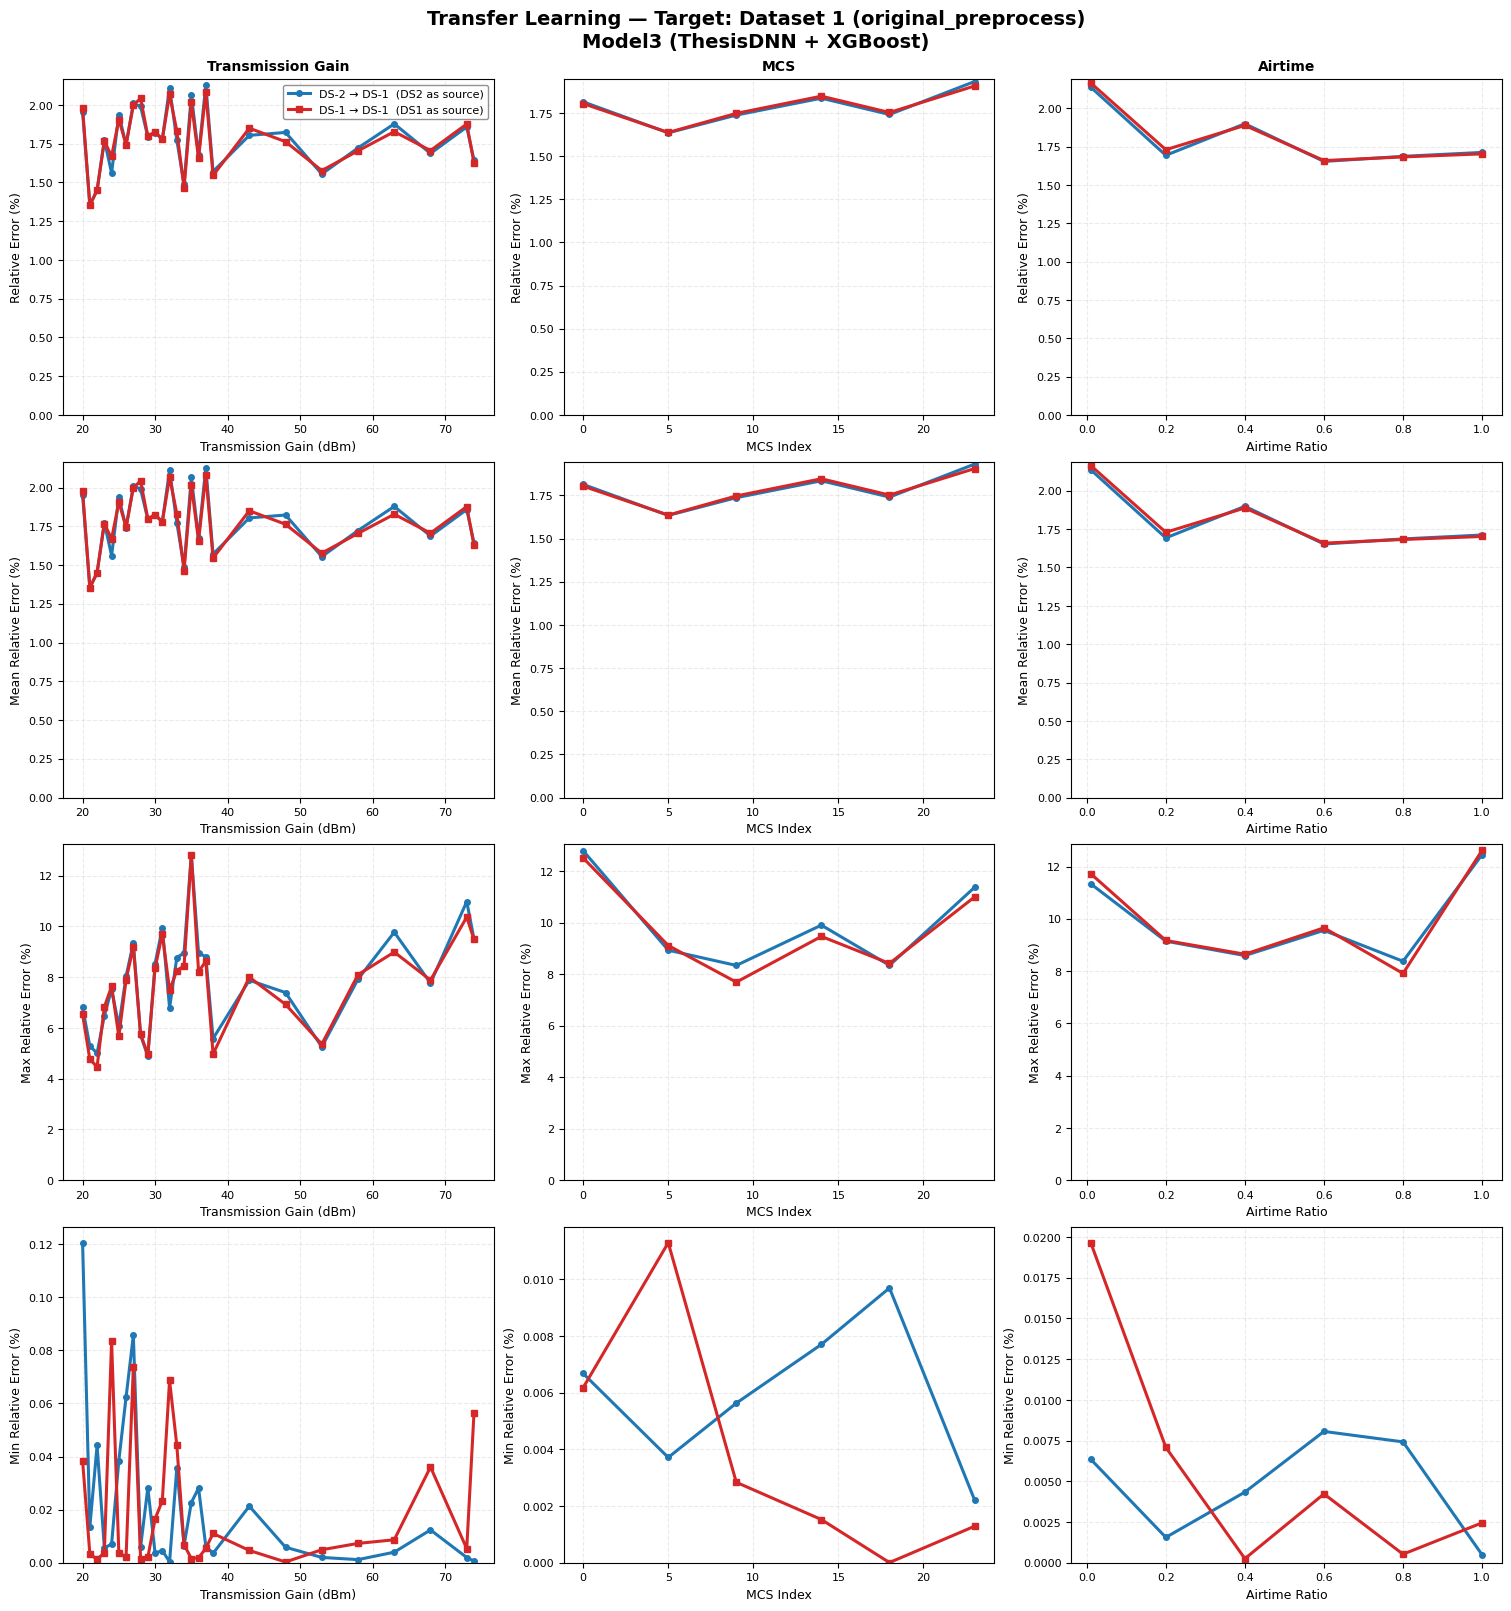

In [16]:
# ─────────────────────────────────────────────────────────────
# 13)  Figure 1 — Target = Dataset 1 (orig)
#      Blue  : DS-2 → DS-1  (Dataset2 as source)
#      Red   : DS-1 → DS-1  (Dataset1 as source / self-transfer)
# ─────────────────────────────────────────────────────────────
plot_12(
    target_label = "Dataset 1 (original_preprocess)",
    key_src_a    = "DS1_tgt_DS2_src",
    key_src_b    = "DS1_tgt_DS1_src",
    label_a      = "DS-2 → DS-1  (DS2 as source)",
    label_b      = "DS-1 → DS-1  (DS1 as source)",
    output_path  = OUTPUT_FIG_DS1,
)

Saved → transfer_tgt_ds2.png


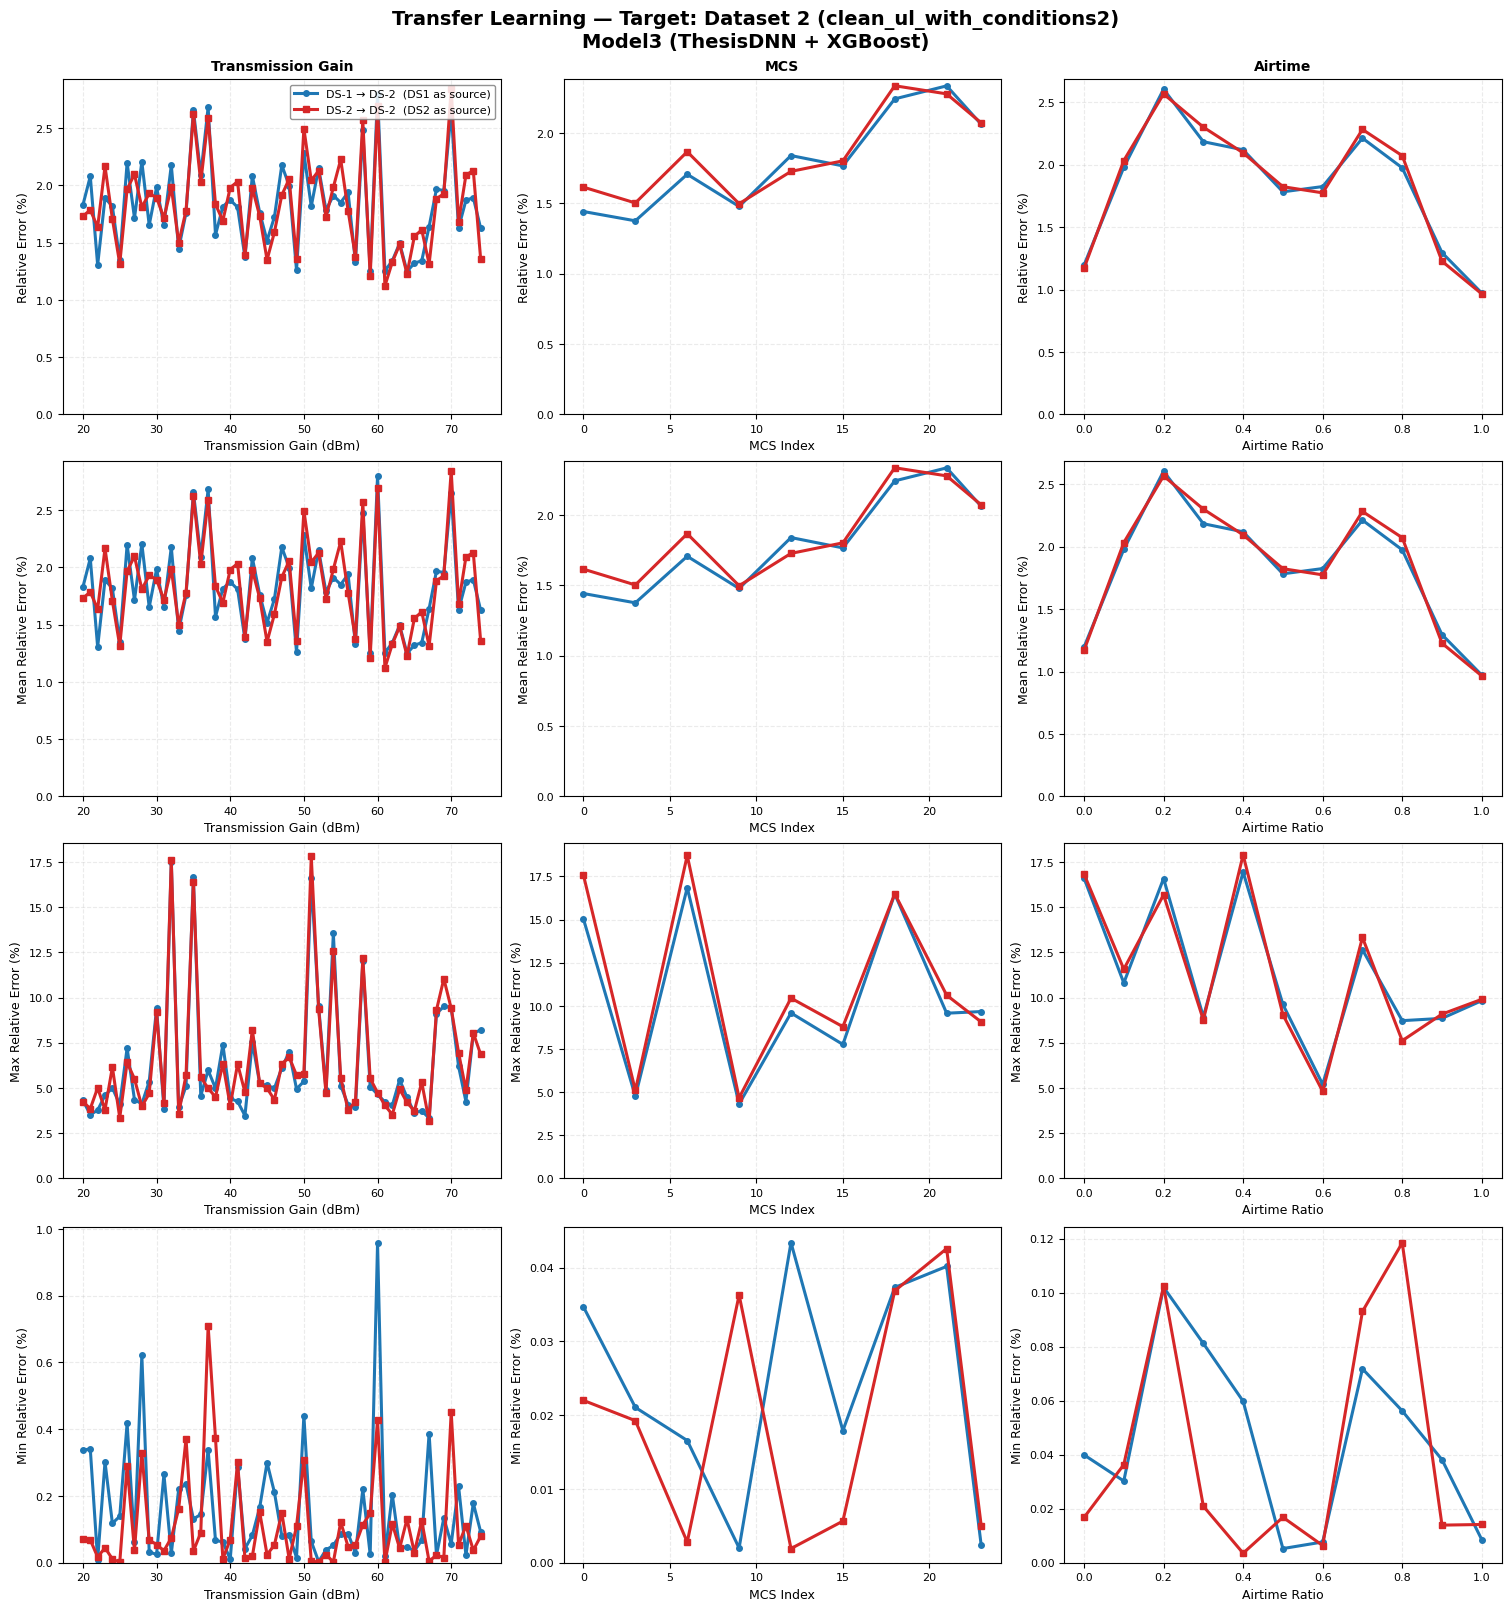

In [17]:
# ─────────────────────────────────────────────────────────────
# 14)  Figure 2 — Target = Dataset 2 (clean)
#      Blue  : DS-1 → DS-2  (Dataset1 as source)
#      Red   : DS-2 → DS-2  (Dataset2 as source / self-transfer)
# ─────────────────────────────────────────────────────────────
plot_12(
    target_label = "Dataset 2 (clean_ul_with_conditions2)",
    key_src_a    = "DS2_tgt_DS1_src",
    key_src_b    = "DS2_tgt_DS2_src",
    label_a      = "DS-1 → DS-2  (DS1 as source)",
    label_b      = "DS-2 → DS-2  (DS2 as source)",
    output_path  = OUTPUT_FIG_DS2,
)

In [18]:
# ─────────────────────────────────────────────────────────────
# 15)  Summary table
# ─────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("SUMMARY: Mean RE (%) per experiment")
print("="*80)
print(f"{'Experiment':<22} {'Direction':<25} {'Mean_RE':>10} {'Max_RE':>10} {'Min_RE':>10}")
print("-"*80)

dir_labels = {
    "DS1_tgt_DS2_src": "DS2→DS1 (target=DS1)",
    "DS1_tgt_DS1_src": "DS1→DS1 (target=DS1)",
    "DS2_tgt_DS1_src": "DS1→DS2 (target=DS2)",
    "DS2_tgt_DS2_src": "DS2→DS2 (target=DS2)",
}

for exp_name in EXPERIMENTS:
    for key, lbl in dir_labels.items():
        st = results[exp_name][key]
        print(f"{exp_name:<22} {lbl:<25} "
              f"{st['mean_re'].mean():>10.2f} "
              f"{st['max_re'].max():>10.2f} "
              f"{st['min_re'].min():>10.2f}")
print("="*80)


SUMMARY: Mean RE (%) per experiment
Experiment             Direction                    Mean_RE     Max_RE     Min_RE
--------------------------------------------------------------------------------
Transmission Gain      DS2→DS1 (target=DS1)            1.78      12.83       0.00
Transmission Gain      DS1→DS1 (target=DS1)            1.77      12.82       0.00
Transmission Gain      DS1→DS2 (target=DS2)            1.82      17.49       0.00
Transmission Gain      DS2→DS2 (target=DS2)            1.84      17.82       0.00
MCS                    DS2→DS1 (target=DS1)            1.78      12.80       0.00
MCS                    DS1→DS1 (target=DS1)            1.78      12.52       0.00
MCS                    DS1→DS2 (target=DS2)            1.80      16.85       0.00
MCS                    DS2→DS2 (target=DS2)            1.85      18.72       0.00
Airtime                DS2→DS1 (target=DS1)            1.80      12.46       0.00
Airtime                DS1→DS1 (target=DS1)            1.80   